# Main imports and code

In [1]:
# check which gpu we're using
!nvidia-smi

Wed Feb 16 23:23:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:81:00.0 Off |                  N/A |
| 42%   27C    P8    29W / 350W |     13MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
!pip install simpletransformers
!pip install tensorboardx

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from urllib import request
import pandas as pd
import logging
import torch
from collections import Counter
from ast import literal_eval

In [3]:
# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# check gpu
cuda_available = torch.cuda.is_available()

print('Cuda available? ',cuda_available)

Cuda available?  True


In [ ]:
# if cuda_available:
#   import tensorflow as tf
#   # Get the GPU device name.
#   device_name = tf.test.gpu_device_name()
#   # The device name should look like the following:
#   if device_name == '/device:GPU:0':
#       print('Found GPU at: {}'.format(device_name))
#   else:
#       raise SystemError('GPU device not found')

# Fetch Don't Patronize Me! data manager module

In [ ]:
# module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
# module_name = module_url.split('/')[-1]
# print(f'Fetching {module_url}')
# #with open("file_1.txt") as f1, open("file_2.txt") as f2
# with request.urlopen(module_url) as f, open(module_name,'w') as outf:
#   a = f.read()
#   outf.write(a.decode('utf-8'))

In [4]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

In [5]:
from dont_patronize_me import DontPatronizeMe

In [6]:
dpm = DontPatronizeMe('.', '.')

In [7]:
dpm.load_task1()
dpm.load_task2(return_one_hot=True)

Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


In [11]:
print(dpm.train_task1_df)

      par_id      art_id     keyword country  \
0          1  @@24942188    hopeless      ph   
1          2  @@21968160     migrant      gh   
2          3  @@16584954   immigrant      ie   
3          4   @@7811231    disabled      nz   
4          5   @@1494111     refugee      ca   
...      ...         ...         ...     ...   
10464  10465  @@14297363       women      lk   
10465  10466  @@70091353  vulnerable      ph   
10466  10467  @@20282330     in-need      ng   
10467  10468  @@16753236    hopeless      in   
10468  10469  @@16779383    homeless      ie   

                                                    text  label orig_label  
0      We 're living in times of absolute insanity , ...      0          0  
1      In Libya today , there are countless number of...      0          0  
2      "White House press secretary Sean Spicer said ...      0          0  
3      Council customers only signs would be displaye...      0          0  
4      """ Just like we received migra

In [28]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

def generate_cloud(label,label_type,df):

    if label_type == "label ":
        text = df[df['label'] == label]['text'].values
    else:
        text = df[df['orig_label'] == label]['text'].values
    
    wordcloud = WordCloud().generate(str(text))
    
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

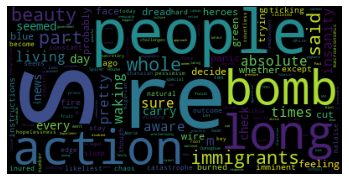

In [19]:
generate_cloud(0,"label ",dpm.train_task1_df)

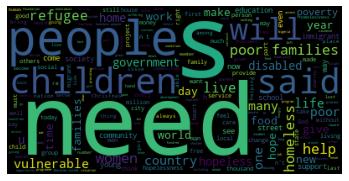

In [20]:
generate_cloud(1,"label ",dpm.train_task1_df)

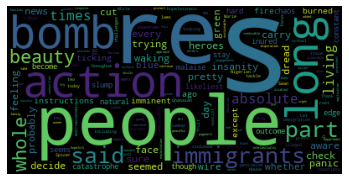

In [29]:
generate_cloud(0,"111",dpm.train_task1_df)

# Load paragraph IDs

In [ ]:
trids = pd.read_csv('train_semeval_parids-labels.csv')
teids = pd.read_csv('dev_semeval_parids-labels.csv')

In [ ]:
trids.head()

In [ ]:
trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)

# Rebuild training set (Task 1)

In [ ]:
rows = [] # will contain par_id, label and text
for idx in range(len(trids)):  
  parid = trids.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label
  })
  

In [ ]:
trdf1 = pd.DataFrame(rows)

# Rebuild test set (Task 1)

In [ ]:
rows = [] # will contain par_id, label and text
for idx in range(len(teids)):  
  parid = teids.par_id[idx]
  #print(parid)
  # select row from original dataset
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label
  })
  

In [ ]:
len(rows)

In [ ]:
tedf1 = pd.DataFrame(rows)

# RoBERTa Baseline for Task 1

In [ ]:
# downsample negative instances
pcldf = trdf1[trdf1.label==1]
npos = len(pcldf)

training_set1 = pd.concat([pcldf,trdf1[trdf1.label==0][:npos*2]])

In [ ]:
training_set1

In [ ]:

task1_model_args = ClassificationArgs(num_train_epochs=1, 
                                      no_save=True, 
                                      no_cache=True, 
                                      overwrite_output_dir=True)
task1_model = ClassificationModel("roberta", 
                                  'roberta-base', 
                                  args = task1_model_args, 
                                  num_labels=2, 
                                  use_cuda=cuda_available)
# train model
task1_model.train_model(training_set1[['text', 'label']])
# run predictions
preds_task1, _ = task1_model.predict(tedf1.text.tolist())

In [ ]:
Counter(preds_task1)

In [ ]:
labels2file([[k] for k in preds_task1], 'task1.txt')

# Rebuild training set (Task 2)

In [ ]:
rows2 = [] # will contain par_id, label and text
for idx in range(len(trids)):  
  parid = trids.par_id[idx]
  label = trids.label[idx]
  # select row from original dataset to retrieve the `text` value
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  rows2.append({
      'par_id':parid,
      'text':text,
      'label':label
  })
  

In [ ]:
trdf2 = pd.DataFrame(rows2)

In [ ]:
trdf2

In [ ]:
trdf2.label = trdf2.label.apply(literal_eval)

# Rebuild test set (Task 2)

In [ ]:
rows2 = [] # will contain par_id, label and text
for idx in range(len(teids)):  
  parid = teids.par_id[idx]
  label = teids.label[idx]
  #print(parid)
  # select row from original dataset to access the `text` value
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  rows2.append({
      'par_id':parid,
      'text':text,
      'label':label
  })
  

In [ ]:
tedf2 = pd.DataFrame(rows2)

In [ ]:
tedf2

In [ ]:
tedf2.label = tedf2.label.apply(literal_eval)

# RoBERTa baseline for Task 2

In [ ]:
all_negs = trdf2[trdf2.label.apply(lambda x:sum(x) == 0)]
all_pos = trdf2[trdf2.label.apply(lambda x:sum(x) > 0)]

training_set2 = pd.concat([all_pos,all_negs[:round(len(all_pos)*0.5)]])

In [ ]:
training_set2

In [ ]:
task2_model_args = MultiLabelClassificationArgs(num_train_epochs=1,
                                                no_save=True, 
                                                no_cache=True, 
                                                overwrite_output_dir=True
                                                )
task2_model = MultiLabelClassificationModel("roberta", 
                                            'roberta-base', 
                                            num_labels=7,
                                            args = task2_model_args, 
                                            use_cuda=cuda_available)
# train model
task2_model.train_model(training_set2[['text', 'label']])
# run predictions
preds_task2, _ = task2_model.predict(tedf2.text.tolist())

In [ ]:
labels2file(preds_task2, 'task2.txt')

## Prepare submission

In [ ]:
!cat task1.txt | head -n 10

In [ ]:
!cat task2.txt | head -n 10

In [ ]:
!zip submission.zip task1.txt task2.txt